<a href="https://colab.research.google.com/github/steve-shim/dlgom/blob/main/opencv/%EB%AA%A8%ED%8F%B4%EB%A6%AC%EC%A7%80_%EB%8B%AB%ED%9E%98_%26_%EC%97%B4%EB%A6%BC_%EC%97%B0%EC%82%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Opening 은 침식->팽창 
### 먼저 침식으로 배경의 잡음(흰색) 제거, 객체 내의 잡음(검정)은 커진다
### 다시 팽창 연산을 수행하면서 객체 내부의 잡음을 원래 크기로 줄인다 (배경의 잡음은 제거된 상태라 영향x)
### 객체 내부에 대한 변화없이 ***배경의 잡음을 제거한다***


## Closing 은 팽창->침식
### 팽창 연산으로 인해서 객체 내부의 잡음(검은색)이 제거되고, 배경의 잡음(흰색)이 증가한다
### 다시 침식 연산을 수행함으로써 배경의 잡음만을 원래 크기로 줄이게 된다 (객체 내부의 잡음은 제거된 상태라 영향x)
### 배경에 대한 변화 없이 ***객체 내부의 잡음을 제거한다***

In [ ]:
from google.colab.patches import cv2_imshow
from google.colab import drive
import os

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/dataset/images'
#data = pd.read_excel(os.path.join(path, fn))

image


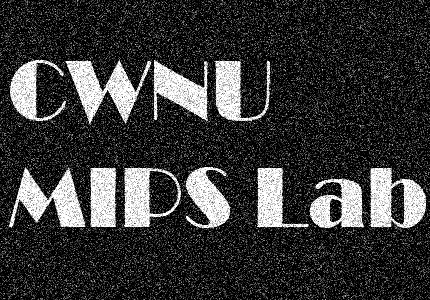

binary image


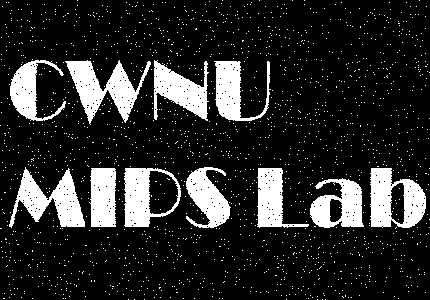

User opening


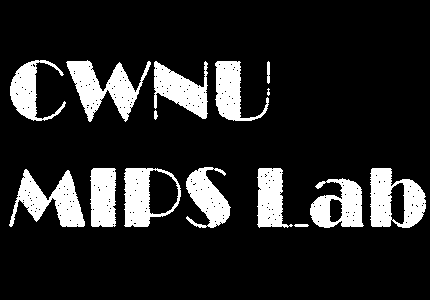

User closing


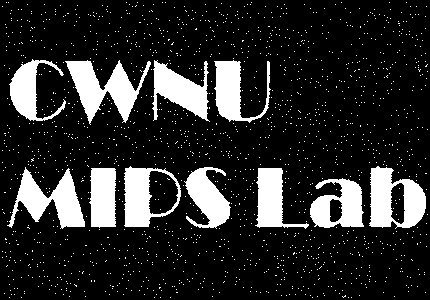

OpenCV opening


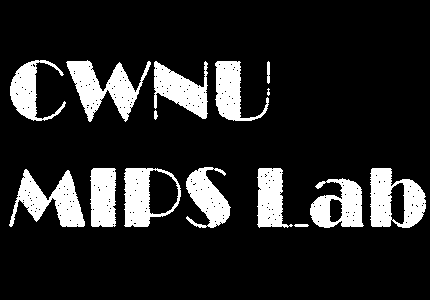

OpenCV closing


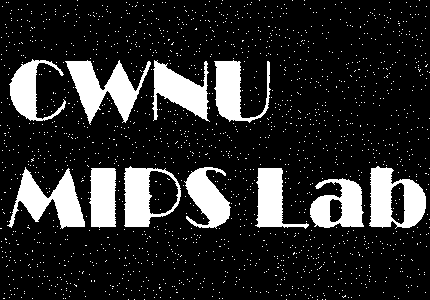

In [ ]:
import numpy as np, cv2

def erode(img, mask=None): # 이진화된 이미지 (300, 430) 가 들어온다 (0~299, 0~429)
    
    dst = np.zeros(img.shape, np.uint8)
    # 잡음이 제거된 결과를 하나씩 기록하는 도화지 같은 역할
    if mask is None: mask = np.ones((3, 3), np.uint8)
    ycenter, xcenter = np.divmod(mask.shape[:2], 2)[0] # (3, 3)을 2로 나눈 몫이 들어간다
    mcnt = cv2.countNonZero(mask) # 5
    
    for i in range(ycenter, img.shape[0] - ycenter):           # 행 (1~298)
        for j in range(xcenter, img.shape[1] - xcenter):       # 열 (1~428)
            y1, y2 = i - ycenter, i + ycenter + 1              # 마스크 높이 범위
            x1, x2 = j - xcenter, j + xcenter + 1              # 마스크 너비 범위
            roi = img[y1:y2, x1:x2]                            # 마스크 영역 (3,3)
            temp = cv2.bitwise_and(roi, mask)                  # (3,3)
            cnt  =  cv2.countNonZero(temp)                     # 일치한 화소수 계산
            dst[i, j] = 255 if (cnt == mcnt) else 0           # 출력 화소에 저장
            # temp의 1의 갯수와 mask의 1의 갯수가 같으면 255저장
            # roi의 255가 mask로 지정한 1들의 덩어리와 똑같던지 커야 해당화소가 살아남는다
            # 잡음은 전부 제거가 된다
    return dst

def dilate(img, mask):
    dst = np.zeros(img.shape, np.uint8)
    if mask is None: mask = np.ones((3, 3), np.uint8)
    ycenter, xcenter = np.divmod(mask.shape[:2], 2)[0]

    for i in range(ycenter, img.shape[0] - ycenter):    # 입력 행렬 반복 순회
        for j in range(xcenter, img.shape[1] - xcenter):
            y1, y2 = i - ycenter, i + ycenter + 1       # 마스크 높이 범위
            x1, x2 = j - xcenter, j + xcenter + 1       # 마스크 너비 범위
            roi = img[y1:y2, x1:x2]                     # 마스크 영역
            temp = cv2.bitwise_and(roi, mask)
            cnt  = cv2.countNonZero(temp)
            dst[i, j] = 0 if (cnt == 0) else 255  # 출력 화소에 저장
    return dst

def opening(img, mask):                     # 열림 연산
    tmp = erode(img, mask)                  # 침식
    dst = dilate(tmp, mask)                 # 팽창
    return dst

def closing(img, mask):                     # 닫힘 연산
    tmp = dilate(img, mask)
    dst = erode(tmp, mask)
    return dst

image = cv2.imread(path + "/morph.jpg", cv2.IMREAD_GRAYSCALE)
if image is None: raise Exception("영상파일 읽기 오류")

mask = np.array([[0, 1, 0],                 # 마스크 초기화
                 [1, 1, 1], 
                 [0, 1, 0]]).astype("uint8")
th_img = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)[1]   # 영상 이진화

dst1 = opening(th_img, mask)                            # 사용자 정의 열림 함수 호출
dst2 = closing(th_img, mask)                            # 사용자 정의 닫힘 함수 호출
dst3 = cv2.morphologyEx(th_img, cv2.MORPH_OPEN, mask)   # OpenCV의 열림 함수
dst4 = cv2.morphologyEx(th_img, cv2.MORPH_CLOSE, mask, iterations=1)  # OpenCV의 닫힘 함수

print("image")
cv2_imshow(image) 
print("binary image")
cv2_imshow(th_img) 
print("User opening")
cv2_imshow(dst1) 
print("User closing")
cv2_imshow(dst2)
print("OpenCV opening")
cv2_imshow(dst3)
print("OpenCV closing")
cv2_imshow(dst4) 
# cv2.waitKey(0)
# cv2.destroyAllWindows()

### 침식 연산의 결과로 배경 부분에 있는 잡음들(흰색)이 제거된 것을 볼 수 있다. 

### 하지만 객체가 침식되므로 객체(글자) 내부의 작은 공간(검은색)은 더 넓어진다.


image


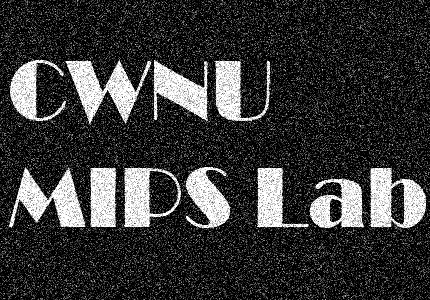

binary image


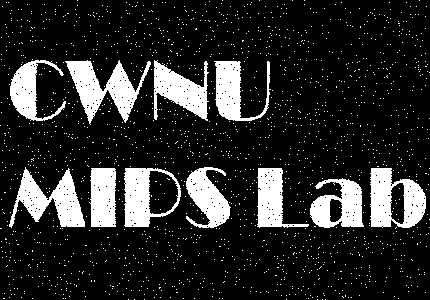

User erode


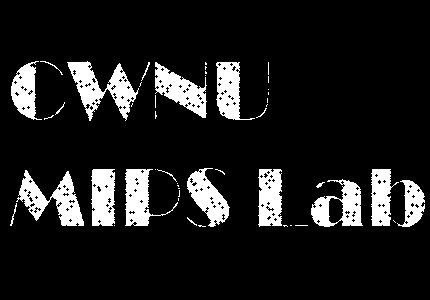

OpenCV erode


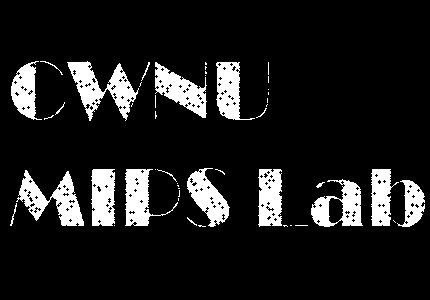

In [ ]:
### 침식 연산의 결과로 배경 부분에 있는 잡음들(흰색)이 제거된 것을 볼 수 있다. 그런데 객체가 침식되므로 객체(글자) 내부의 작은 공간(검은색)은 더 넓어진다.

import numpy as np, cv2

def erode(img, mask=None): # 이진화된 이미지 (300, 430) 가 들어온다 (0~299, 0~429)
    
    dst = np.zeros(img.shape, np.uint8)
    # 잡음이 제거된 결과를 하나씩 기록하는 도화지 같은 역할
    if mask is None: mask = np.ones((3, 3), np.uint8)
    ycenter, xcenter = np.divmod(mask.shape[:2], 2)[0] # (3, 3)을 2로 나눈 몫이 들어간다
    mcnt = cv2.countNonZero(mask) # 5
    
    for i in range(ycenter, img.shape[0] - ycenter):           # 행 (1~298)
        for j in range(xcenter, img.shape[1] - xcenter):       # 열 (1~428)
            y1, y2 = i - ycenter, i + ycenter + 1              # 마스크 높이 범위
            x1, x2 = j - xcenter, j + xcenter + 1              # 마스크 너비 범위
            roi = img[y1:y2, x1:x2]                            # 마스크 영역 (3,3)
            temp = cv2.bitwise_and(roi, mask)                  # (3,3)
            cnt  =  cv2.countNonZero(temp)                     # 일치한 화소수 계산
            dst[i, j] = 255 if (cnt == mcnt) else 0           # 출력 화소에 저장
            # temp의 1의 갯수와 mask의 1의 갯수가 같으면 255저장
            # roi의 255가 mask로 지정한 1들의 덩어리와 똑같던지 커야 해당화소가 살아남는다
            # 잡음은 전부 제거가 된다
    return dst

image = cv2.imread(path + "/morph.jpg", cv2.IMREAD_GRAYSCALE)
if image is None: raise Exception("영상파일 읽기 오류")

data = [0, 1, 0,                                               # 마스크 선언 및 초기화
        1, 1, 1,
        0, 1, 0]
mask = np.array(data, np.uint8).reshape(3, 3)
th_img = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)[1]  # 영상 이진화
# 128보다 작은 값은 0(검은색)으로 지정, 128 이상인 값은 255(흰색)으로 지정

dst1 = erode(th_img, mask)  # 사용자 정의 침식 함수 mask 행렬로 침식 연산 수행
dst2 = cv2.erode(th_img, mask)
# dst2 = cv2.morphologyEx(th_img, cv2.MORPH_ERODE, mask)         
# OpenCV의 침식 함수

print("image")
cv2_imshow(image)
print("binary image")
cv2_imshow(th_img)
print("User erode")
cv2_imshow(dst1)
print("OpenCV erode")
cv2_imshow(dst2)


### 팽창 연산의 수행결과로 객체들이 전반적으로 확장되어 뚜렷하게 나타나고, 객체 내부의 빈 공간이 메워진다. 

### 하지만 배경부분의 잡음들도 확장된다

image


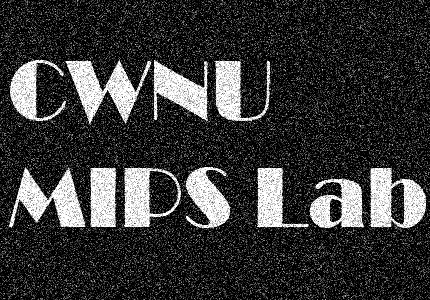

binary image


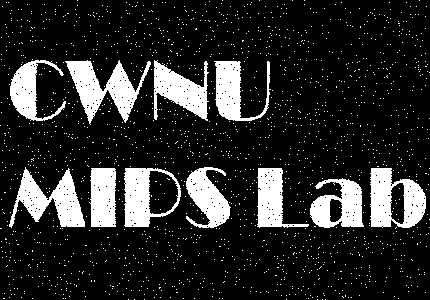

User dilate


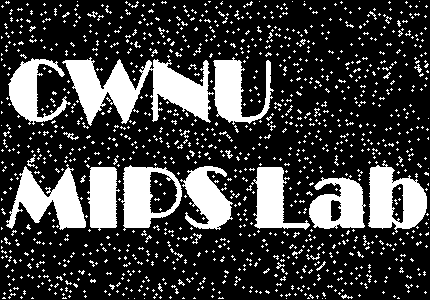

OpenCV dilate


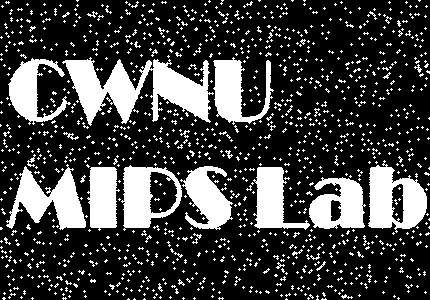

In [ ]:
### 팽창 연산의 수행결과로 객체들이 전반적으로 확장되어 뚜렷하게 나타나고, 객체 내부의 빈 공간이 메워진다. but 배경부분의 답음들도 확장된다
import numpy as np, cv2

def dilate(img, mask):
    dst = np.zeros(img.shape, np.uint8)
    if mask is None: mask = np.ones((3, 3), np.uint8)
    ycenter, xcenter = np.divmod(mask.shape[:2], 2)[0]

    for i in range(ycenter, img.shape[0] - ycenter):    # 입력 행렬 반복 순회
        for j in range(xcenter, img.shape[1] - xcenter):
            y1, y2 = i - ycenter, i + ycenter + 1       # 마스크 높이 범위
            x1, x2 = j - xcenter, j + xcenter + 1       # 마스크 너비 범위
            roi = img[y1:y2, x1:x2]                     # 마스크 영역
            temp = cv2.bitwise_and(roi, mask)
            cnt  = cv2.countNonZero(temp)
            dst[i, j] = 0 if (cnt == 0) else 255  # 출력 화소에 저장
    return dst

image = cv2.imread(path + "/morph.jpg", cv2.IMREAD_GRAYSCALE)
if image is None: raise Exception("영상파일 읽기 오류")

mask = np.array([[0, 1, 0],                         # 마스크 초기화
                 [1, 1, 1],
                 [0, 1, 0]]).astype("uint8")
th_img = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)[1]  # 영상 이진화
dst1 = dilate(th_img, mask)                              # 사용자 정의 팽창 함수
dst2 = cv2.morphologyEx(th_img, cv2.MORPH_DILATE, mask)  # OpenCV의 팽창 함수
# dst2 = cv2.dilate(th_img, mask)


print("image")
cv2_imshow(image)
print("binary image")
cv2_imshow(th_img)
print("User dilate")
cv2_imshow(dst1)
print("OpenCV dilate")
cv2_imshow(dst2)
